In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from pathlib import Path
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

# Assignment 6 Kamryn Parker

## Part One: Load and Prepare the Data

In [2]:
rng = np.random.RandomState(521236558)

In [3]:
articles = pd.DataFrame.from_records(
    ((f.parent.name, f.name, f.read_text(encoding='latin1'))
     for f in Path('bbc').glob('*/*.txt')),
    columns=['category', 'file', 'text']
)

First thing I will do after getting the data set loaded is set aside 20% into a sample test set my classifier.

In [4]:
test_articles = articles.sample(frac=0.20, random_state=rng)

train_mask = pd.Series(True, index=articles.index)
train_mask[test_articles.index] = False
train_articles = articles[train_mask]

Next, lets look at the distribution of the data set as a whole.

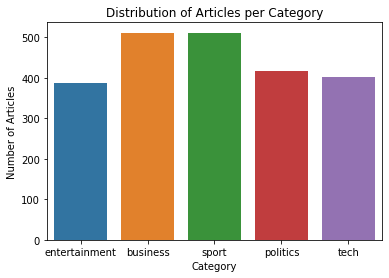

In [5]:
ax = sns.countplot(x="category", data=articles)
ax = ax.set(title = 'Distribution of Articles per Category', xlabel = 'Category', ylabel = 'Number of Articles')

In [6]:
articles['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

Looking at the distribution and the value counts of each category we can see that the sports category has the most articles. However, business is not far off with 510 articles.

Let's look at the distributions of both our test and training data.

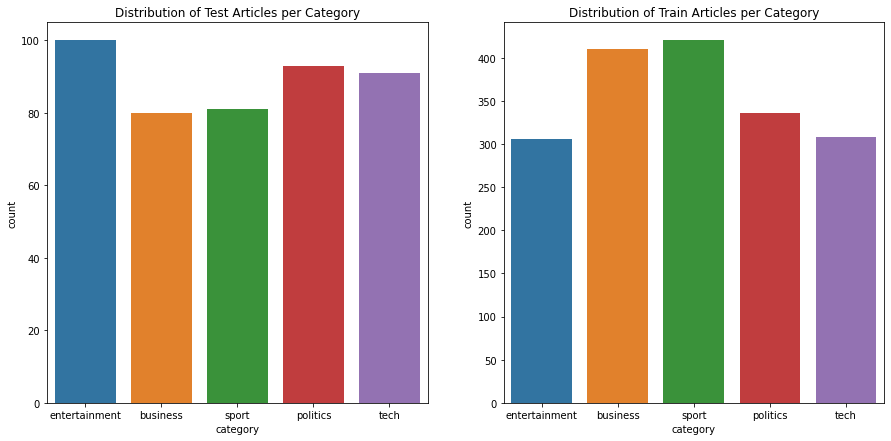

In [7]:
fig, ax =plt.subplots(1,2,figsize=(15, 7), sharex=True)
sns.countplot(x="category", data=test_articles,ax=ax[0])
sns.countplot(x="category", data=train_articles,ax=ax[1])
ax[0].title.set_text('Distribution of Test Articles per Category')
ax[1].title.set_text('Distribution of Train Articles per Category')

This looks like a pretty good and even distribution of values per sample set. Lets start training some classifiers!!

## Part Two: Classification

### Naive Bayes
I will start with a Naive Bayes Classifier and get the accuracy of both the train set and test set.

In [8]:
bayes_pipe = Pipeline([
    ('word_count', CountVectorizer()),
    ('classify', MultinomialNB())
])
bayes_pipe.fit(train_articles['text'], train_articles['category'])

Pipeline(steps=[('word_count', CountVectorizer()),
                ('classify', MultinomialNB())])

In [9]:
print('Train set Naive Bayes Accuracy:',str(accuracy_score(train_articles['category'],
                                               bayes_pipe.predict(train_articles['text']))))
print('Test set Naive Bayes Accuracy:',str(accuracy_score(test_articles['category'],
                                              bayes_pipe.predict(test_articles['text']))))

Train set Naive Bayes Accuracy: 0.9955056179775281
Test set Naive Bayes Accuracy: 0.9595505617977528


Very impressive model statistics with amlost 100% accuracy for our training data and 95% for our test set. Hmmmm, we will need to see how this compares to the rest of our classifiers to see if its on par or vastly different. I think this one may not be realistic but lets check the others to see!

### KNN Classifier
The next one will be the KNN classifier. I decided to do a stopword removal just so that there isn't a bunch of words included in our analysis. I did this to ensure the classifier focuses on more terms that would be unique to that category. Like for example, entertainment should see more 'actor', 'film', or 'idustry' type words than 'he', 'her', or 'them' which could happen considering entertainment deals with people and they would use pronouns to refer to these folks.

In [10]:
knn_pipe = Pipeline([
    ('vector', TfidfVectorizer(stop_words = stopwords.words('english'))),
    ('classify', KNeighborsClassifier(n_neighbors=5))
])
knn_pipe.fit(train_articles['text'], train_articles['category'])

Pipeline(steps=[('vector',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('classify', KNeighborsClassifier())])

In [11]:
print('Train set Accuracy:', str(accuracy_score(train_articles['category'],knn_pipe.predict(train_articles['text']))))
print('Test set Accuracy:', str(accuracy_score(test_articles['category'], knn_pipe.predict(test_articles['text']))))

Train set Accuracy: 0.9623595505617978
Test set Accuracy: 0.9303370786516854


Our accuracy it pretty high as well although this one seems to be a little more realistic than our Naive Bayes classifier.

### KNN Grid Search
Now we will implent our KNN Classifier with a Grid Search CV to find the best KNN neighbor size. I will keep the same stopword list for this model as well.

In [12]:
knn_grid_pipe = Pipeline([
    ('vector', TfidfVectorizer(stop_words = stopwords.words('english'))),
    ('classify', GridSearchCV(KNeighborsClassifier(), {
    'n_neighbors': [1, 2, 3, 5, 7, 10]},scoring=make_scorer(accuracy_score)))
])
knn_grid_pipe.fit(train_articles['text'], train_articles['category'])

Pipeline(steps=[('vector',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('classify',
                 GridSearchCV(estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 5, 7, 10]},
                              scoring=make_scorer(accuracy_score)))])

In [13]:
print('Train set Accuracy:', str(accuracy_score(train_articles['category'],
                                                knn_grid_pipe.predict(train_articles['text']))))
print('Test set Accuracy:', str(accuracy_score(test_articles['category'],
                                               knn_grid_pipe.predict(test_articles['text']))))

Train set Accuracy: 0.9595505617977528
Test set Accuracy: 0.9393258426966292


In [14]:
knn_grid_pipe.named_steps['classify'].best_params_

{'n_neighbors': 10}

Our accuracy for the KNN Grid search is a little lower on our training set than our normal KNN but it is slightly higher on the test set! So, this method did help us out some with our classifier. We can see our n_neighbors chose 10 as well meaning there is less noise in with our set but ther may be have a bit less distinct boundaries between each class.

## Part Three: Dimensionality Reduction

In [15]:
from sklearn.decomposition import TruncatedSVD
svd_pipe = Pipeline([
    ('word_vec', TfidfVectorizer(stop_words = stopwords.words('english'))),
    ('svd', TruncatedSVD(8))
])
svd_pipe.fit(train_articles['text'])
text_vectors = svd_pipe.transform(train_articles['text'])

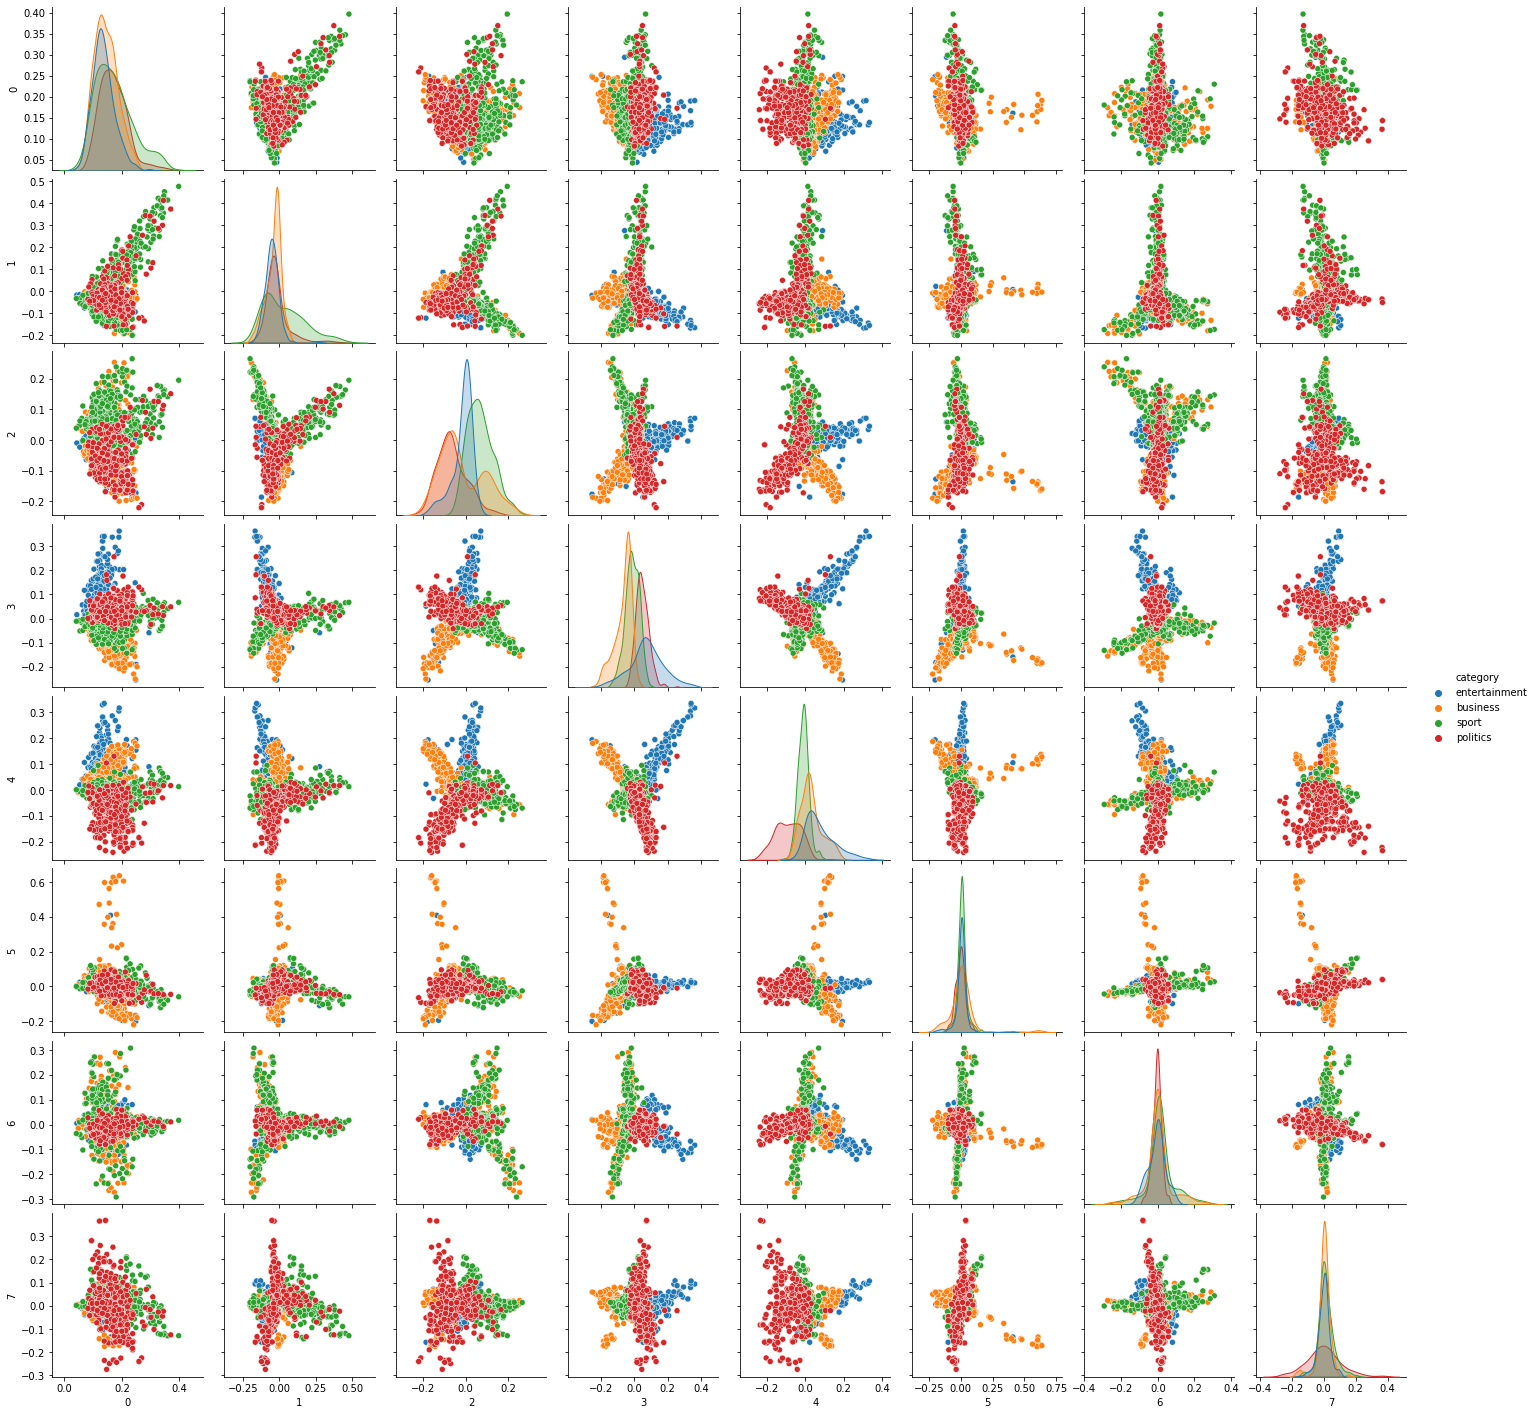

In [16]:
df_text = pd.DataFrame(text_vectors)
df_text['category'] = train_articles['category']
text_plot = sns.pairplot(df_text, hue = 'category')

Looking at the plot the first thing I notice is that the category 'tech' is missing. It is almost like the dimesion reductiong reduced the train set so much that it reduced out the 'tech' category. I can also see though that the category 'politics' stays clustered toward the center while 'entertainment', 'sports', and business' tend to spread out more. This could be becasue politics may have more terms similar with all of these categories so it doesn't have to spread out as much whereas sports looks like it spreads out a lot and the SVD helped reduce its differences among the other articles.

In [17]:
knn_svd_pipe = Pipeline([
    ('word_vec', TfidfVectorizer(stop_words = stopwords.words('english'))),
    ('svd', TruncatedSVD(8)),
    ('classify', KNeighborsClassifier(n_neighbors=5))
    
])
knn_svd_pipe.fit(train_articles['text'],train_articles['category'])

Pipeline(steps=[('word_vec',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('svd', TruncatedSVD(n_components=8)),
                ('classify', KNeighborsClassifier())])

In [18]:
print('Train set Accuracy:', str(accuracy_score(train_articles['category'],
                                                knn_svd_pipe.predict(train_articles['text']))))
print('Test set Accuracy:', str(accuracy_score(test_articles['category'],
                                               knn_svd_pipe.predict(test_articles['text']))))

Train set Accuracy: 0.9724719101123596
Test set Accuracy: 0.9370786516853933


Running this classifier I didn't see too much of a difference in the accuracies. It has a slightly higer accuracy for the train set than our KNN GridCV but just barley a lower test accuracy. So, this one did not make too much difference.

## Part Four: Summarizing Classifier Accuracy
Now let's get all of these accuracies into one place and plot them to see how different they are. I will first start with setting them all to a data frame and melting them together to make it easier to plot.

In [19]:
d = {'DataSet': ['Train', 'Test'], 
     'Naive Bayes': [accuracy_score(train_articles['category'],bayes_pipe.predict(train_articles['text'])), 
                    accuracy_score(test_articles['category'], bayes_pipe.predict(test_articles['text']))],
     'KNN':[accuracy_score(train_articles['category'],knn_pipe.predict(train_articles['text'])), 
                    accuracy_score(test_articles['category'], knn_pipe.predict(test_articles['text']))],
     'KNN Grid Search':[accuracy_score(train_articles['category'],knn_grid_pipe.predict(train_articles['text'])), 
                    accuracy_score(test_articles['category'], knn_grid_pipe.predict(test_articles['text']))],
     'KNN SVD': [accuracy_score(train_articles['category'],knn_svd_pipe.predict(train_articles['text'])), 
                    accuracy_score(test_articles['category'], knn_svd_pipe.predict(test_articles['text']))]}
df = pd.DataFrame(data=d)

In [20]:
df_melt = df.melt(id_vars=['DataSet'])

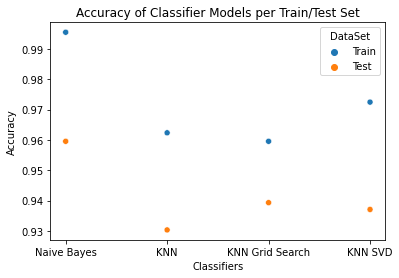

In [21]:
plt1 = sns.scatterplot(x="variable", y = 'value', hue = 'DataSet', data = df_melt)
plt1 = plt1.set(title = 'Accuracy of Classifier Models per Train/Test Set', xlabel ='Classifiers',ylabel ='Accuracy')

From the look of our classifier accuracy our original assumptions about the Naive Bayes classifier looks to be right. There may be some overfitting that is happening to this classifier since it is so much higher than the rest of any of our other classifiers. Even the test data accuracy is almost at the same level as our other training set's accuracies.

Overall, disregarding the Naive Bayes, it looks like our KNN SVD had the best accuracy for our train set but the KNN Grid Search had the best results for our test set!

### GridSearchCV on KNN and SVD

In [22]:
knn_grid_svd_pipe = Pipeline([
    ("word_vec", TfidfVectorizer(stop_words = stopwords.words('english'))), 
    ("svd", TruncatedSVD()),
    ('classify', KNeighborsClassifier())
])

param_grid = {
    "svd__n_components": [1, 2, 3, 4, 5, 6, 7, 8],
    "classify__n_neighbors": [1, 2, 3, 5, 7, 10]
}

search = GridSearchCV(knn_grid_svd_pipe, param_grid,scoring='accuracy')
search.fit(train_articles['text'],train_articles['category'])

GridSearchCV(estimator=Pipeline(steps=[('word_vec',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                 

In [23]:
print('Train set Accuracy:', str(accuracy_score(train_articles['category'],search.predict(train_articles['text']))))
print('Test set Accuracy:', str(accuracy_score(test_articles['category'],
                                               search.predict(test_articles['text']))))

Train set Accuracy: 0.9780898876404495
Test set Accuracy: 0.9325842696629213


Now let's compare this accuracy to our other classifiers by adding it to our data frame and plotting again. I will be using the .loc function to add a new row for each train and test accuracy score.

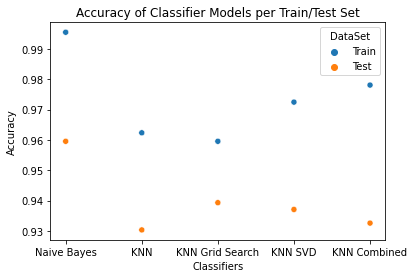

In [24]:
new = ['Train','KNN Combined',accuracy_score(train_articles['category'],search.predict(train_articles['text']))]
new_test = ['Test','KNN Combined',accuracy_score(test_articles['category'],search.predict(test_articles['text']))]

df_melt.loc[8] = new
df_melt.loc[9] = new_test

plt3 = sns.scatterplot(x="variable", y = 'value', hue = 'DataSet', data = df_melt)
plt3 = plt3.set(title = 'Accuracy of Classifier Models per Train/Test Set', xlabel ='Classifiers',ylabel ='Accuracy')

We can see from our new plot that the train accuracy improved by a lot but our test accuracy did not. We can see that our KNN Grid Search still did the best with our test accuracy overall. So, I would probably choose that model for future test sets.

## Part Five: Clustering

In [25]:
k_means_pipe = Pipeline([
    ('word_vec', TfidfVectorizer(stop_words = stopwords.words('english'))),
    ('k_means', KMeans(5, random_state=rng))
])
k_means_pipe.fit(articles['text'])
k_preds = k_means_pipe.predict(articles['text'])
k_transform = k_means_pipe.transform(articles['text'])
# get results in clusters, match those cluster numbers with categories

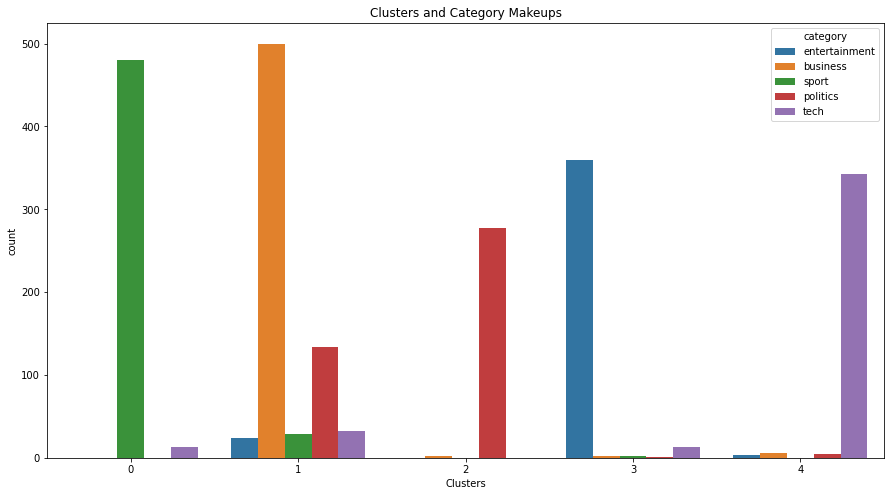

In [26]:
cluster_df = pd.DataFrame(k_preds, columns = ['cluster'])
cluster_df['category'] = articles['category']

plt.figure(figsize = (15,8))
clust_plot = sns.countplot(x='cluster', hue = 'category', data = cluster_df)
clust_plot = clust_plot.set(title = 'Clusters and Category Makeups', xlabel = 'Clusters')

Personally, I think this classifier did a pretty good job of clustering each category eparatley. It looks like it struggled a little bit where it classifies business as a majority in cluster 1 but also has over 100 atricles labeled politics in that same cluster. Beyond that, the rest of the clusters did a pretty good job of having a clear majority article cateogory for each.

Now, lets take a look at which cluster had the best. I would say just by the majority cluster 2 did the best with the most business articles calssified there but cluster 3 is almost exclusivley sports so let's look at cluster 3's terms.

In [27]:
clust_centers = pd.DataFrame(np.array(k_means_pipe.named_steps['k_means'].cluster_centers_)).T
features = pd.DataFrame(k_means_pipe.named_steps['word_vec'].get_feature_names(), columns = ['Terms'])
merge = pd.merge(clust_centers, features, left_index=True, right_index=True)
merge[[0,'Terms']].sort_values(by = 0, ascending = False).head(10)

,0,Terms
11526,0.034333,game
9648,0.032648,england
28749,0.027024,win
22950,0.025153,said
7387,0.024150,cup
16772,0.023295,match
26125,0.022560,team
20081,0.022428,players
14026,0.021373,injury
10810,0.021361,first


Looking at the top 10 terms these make a lot of sense as for matching with sports. It also makes sense why there are a few 'tech' articles in here too becasue they may discuss a video 'game' which this cluster said 'game' was their top mentioned (or weighted) term.

In [28]:
k_means_pipe_new = Pipeline([
    ('word_vec', TfidfVectorizer(stop_words = stopwords.words('english'))),
    ('k_means', KMeans(6, random_state=rng))
])
k_means_pipe_new.fit(articles['text'])
k_preds_new = k_means_pipe_new.predict(articles['text'])
k_transform_new = k_means_pipe_new.transform(articles['text'])

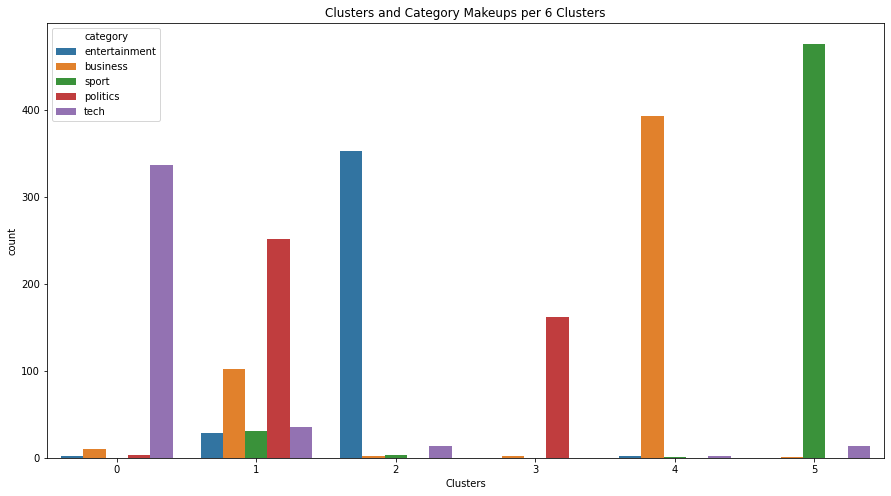

In [29]:
cluster_df_new = pd.DataFrame(k_preds_new, columns = ['cluster'])
cluster_df_new['category'] = articles['category']

plt.figure(figsize = (15,8))
clust_plot_new = sns.countplot(x='cluster', hue = 'category', data = cluster_df_new)
clust_plot_new = clust_plot_new.set(title = 'Clusters and Category Makeups per 6 Clusters', xlabel = 'Clusters')

It looks like this classifier had a little bit more trouble with 6 clusters becasue looking at the chart there is a large amount of various categories clustered around the 1 cluster. However, the rest of the clusters seem to do a good job specifying a majority category for each cluster. Cluster 3 did a phenominal job with clasifying sports is looks like with barley any other article categories in that one. However, I would probabbly go with the 5 cluster classifier just becasue I have only 5 article cateogries and this one struggled with adding a 6th.

Since we looked at sports in the the cluster 5 kmeans let's instead take a look at the cluster that this model struggled with the most. So, cluster number 1 is the one we will look at to see what terms it got mixed up with.

In [32]:
clust_centers_new = pd.DataFrame(k_means_pipe_new.named_steps['k_means'].cluster_centers_).T
features_new = pd.DataFrame(k_means_pipe_new.named_steps['word_vec'].get_feature_names(), columns = ['Terms'])
new_merge = pd.merge(clust_centers_new, features_new, left_index=True, right_index=True)

new_merge[[1,'Terms']].sort_values(by = 1, ascending = False).head(15)

,1,Terms
22950,0.050297,said
17785,0.040068,mr
12066,0.032628,government
28973,0.026377,would
9924,0.020833,eu
15557,0.019898,law
19650,0.018736,people
7044,0.017298,could
27784,0.017165,us
29193,0.017044,yukos


So, from looking at our chart it seems it classified 'politics' and business' the most in this cluster and the other three just about at equal level. From the look of the top 15 terms it makes some sense why the cluster was confused. the terms 'said' and 'mr' were the most highly weighted which are both terms I could see to being used for either article. Also 'government' and 'law' are highly used terms which seems like it would be more helpful for the politics cluster but, at the same time those terms could be used in business articles since a lot of business is done depending on how the government is doing and how different laws are followed. 

## Reflection

I found this assignment to be not too bad in terms of complexity. It felt a lot like a puzzle puttig the pieces together with the different pipelines. I didn't use the pipelines in Assignment 5 so it was challenging yet intriguing to work with them on this project. So, I learned a lot from the pipelines this assignment and all the different nuances for pulling out paramters and things from them.

I think this solidified a lot of things I learned in Information Retrieval with Dr. Pera. I made some inferences with the data like deciding to use the stop words list. I think if I were to enhance the model even more I would strip all non alphabetic characters becasue when I looked at the text there were some odd values like '003t' and such that may be helpful to pull out of the text processing. I really liked seeing the terms that were associated with each cluster too because it was intersting to see which terms were most used for classification. Especially business and politics looked to use 'mr' as a really high indicator for both so, it was easy to see why an article would be mistaken for business or vice versa. I also appreciated seeing the difference in KMeans becasue it shows that you have to have some inference or understanding of your data to know

I was overall surprised that the KNN Grid Search ended up being the best among the test accuracies. I think that is becasue there is so much dimensionality with the data that there is ought to be more for the model to learn to help classify compared to reducing the dimensions with the other models. Overall, I think this assignment taught me a lot about text processing in that you can use many different models and techniques explore how the text interacts with each category.